<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/05_01_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple anomaly detection based on image features extracted by VGG16 network.



Prepare images of various guitars, and images that are not similar to guitars. Can you find an image that is not a guitar?

In [1]:
# Download the guitar images. It'll take a while.
!wget https://dl.dropbox.com/s/dmjzsrqa9s22joi/imgs.zip
!unzip -d . imgs.zip

--2022-01-19 12:43:17--  https://dl.dropbox.com/s/dmjzsrqa9s22joi/imgs.zip
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/dmjzsrqa9s22joi/imgs.zip [following]
--2022-01-19 12:43:17--  https://dl.dropboxusercontent.com/s/dmjzsrqa9s22joi/imgs.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.3.15, 2620:100:6018:15::a27d:30f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.3.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25799813 (25M) [application/zip]
Saving to: ‘imgs.zip’

imgs.zip            100%[===================>]  24.60M  29.4MB/s    in 0.8s    

2022-01-19 12:43:19 (29.4 MB/s) - ‘imgs.zip’ saved [25799813/25799813]

Archive:  imgs.zip
  inflating: ./imgs/guitar/1.yamaha_cs40jgg_la.jpg 

In [13]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import models, optimizers, layers
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
#from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from sklearn.svm import OneClassSVM

import glob  
from PIL import Image 
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.image as mpimg
import random

## Adjust the size of the image

In [7]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

## Bring up the generic learned network VGG16.

In [8]:
model = VGG16(weights='imagenet', include_top=False, pooling="avg")

58900480/58889256 [==============================] - 0s 0us/step


## Prepare a function to extract features from an image

In [14]:
def feature_extraction(model, img_path, image_size=224):
    im=load_img(f)
    img = expand2square(im, (128, 128, 128)).resize((image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # add a dimention of samples
    x = preprocess_input(x)  # RGB 2 BGR and zero-centering by mean pixel based on the position of channels

    feat = model.predict(x)  # Get image features
    feat = feat.flatten()  # Convert 3-dimentional matrix to (1, n) array

    return feat

## Feature Extraction of Guitar Image

./imgs/guitar/extened-31_0_2893.jpg


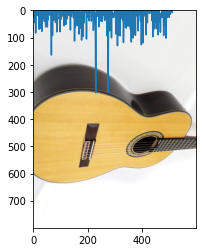

./imgs/guitar/extened-22_0_98.jpg


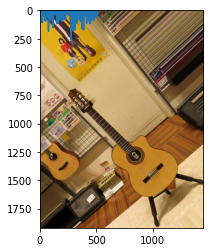

./imgs/guitar/extened-39_0_198.jpg


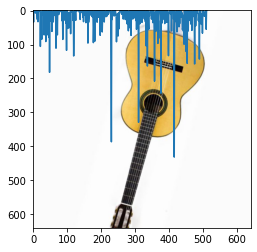

In [15]:

files = glob.glob("./imgs/guitar/*") 
# test
for f in random.sample(files, 3):
  print(f)
  ret= feature_extraction(model, f, 224)
  plt.imshow(mpimg.imread(f))
  plt.plot(ret*10)
  plt.show()

In [16]:
# Perform feature extraction of all guitar images. It takes quite some time.
data=[]
for f in files:
        print(f)
        ret= feature_extraction(model, f, 224)
        data.append(ret)

./imgs/guitar/extened-8_0_1659.jpg
./imgs/guitar/extened-16_0_1672.jpg
./imgs/guitar/extened-8_0_5629.jpg
./imgs/guitar/extened-12_0_1652.jpg
./imgs/guitar/extened-18_0_8163.jpg
./imgs/guitar/extened-14_0_5721.jpg
./imgs/guitar/extened-9_0_7077.jpg
./imgs/guitar/extened-44_0_2951.jpg
./imgs/guitar/extened-28_0_4878.jpg
./imgs/guitar/extened-6_0_9594.jpg
./imgs/guitar/18.mono24777839-180718-02.jpg
./imgs/guitar/extened-16_0_3583.jpg
./imgs/guitar/extened-25_0_9983.jpg
./imgs/guitar/24.20190929-img_0202.jpg
./imgs/guitar/extened-3_0_4672.jpg
./imgs/guitar/extened-24_0_3121.jpg
./imgs/guitar/extened-23_0_440.jpg
./imgs/guitar/extened-43_0_4651.jpg
./imgs/guitar/extened-25_0_3139.jpg
./imgs/guitar/extened-4_0_595.jpg
./imgs/guitar/extened-11_0_7165.jpg
./imgs/guitar/extened-7_0_7786.jpg
./imgs/guitar/extened-27_0_4226.jpg
./imgs/guitar/extened-9_0_1025.jpg
./imgs/guitar/extened-36_0_3769.jpg
./imgs/guitar/extened-1_0_1620.jpg
./imgs/guitar/extened-15_0_5239.jpg
./imgs/guitar/extened-23_0_3

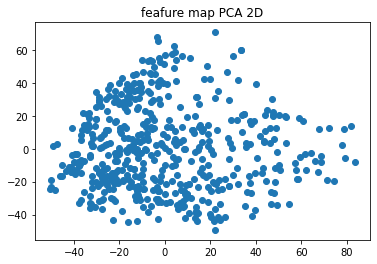

In [20]:
# Let's use PCA to look at the approximate distribution.
data = np.array(data)
pca = PCA(n_components=2)
pdata =np.array(pca.fit_transform(data))
plt.scatter(pdata.T[0],pdata.T[1])
plt.title("feafure map PCA 2D")
plt.show()

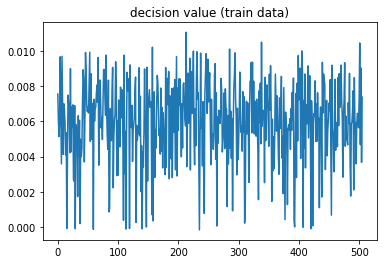

In [21]:
# oneclassSVM
mmscaler = preprocessing.MinMaxScaler() 
mmscaler.fit(data)  
sdata=mmscaler.transform(data)

#decision value
ocsvm = OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
ocsvm.fit(sdata)
y_pred = ocsvm.decision_function(sdata).ravel()
plt.plot(y_pred)
plt.title("decision value (train data)")
plt.show()

### Let's also look for features in images that are not guitars.


./imgs/others/065-00496_m.jpg


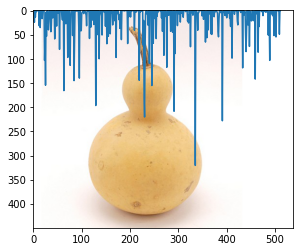

./imgs/others/2016-06-14_Orange_and_white_tabby_cat_born_in_2016_ТГГgГЙФТВ╦В▒_DSCF6526БЩЬc.jpg


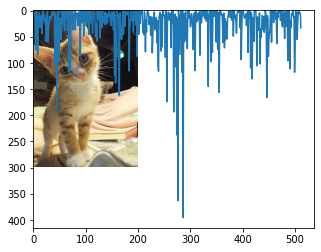

./imgs/others/31OFo14if6L._AC_SS350_.jpg


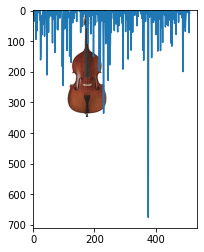

./imgs/others/514N0S1vXRL._SY550_.jpg


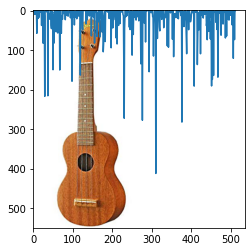

./imgs/others/61xdYKcuO0L._SY355_.jpg


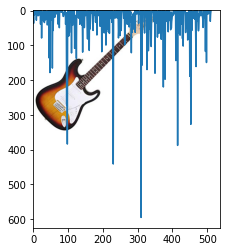

./imgs/others/BAAD5109720944D6B071FDE3916D87B6_12073.jpg


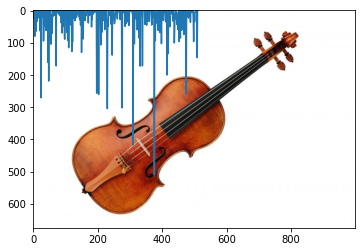

./imgs/others/classic_guitar.png


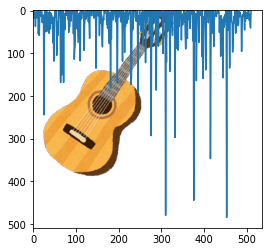

./imgs/others/piano1_yamaha-cfx-bk2.jpg


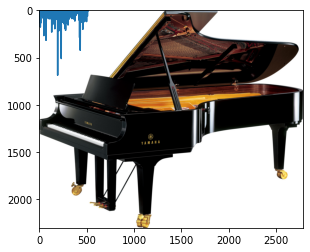

In [22]:
adata=[]
files = glob.glob("./imgs/others/*")   

for f in np.sort(files):
        print(f)
        ret= feature_extraction(model, f, 224)
        plt.imshow(mpimg.imread(f))
        plt.plot(ret*10)
        plt.show()
        adata.append(ret)
adata = np.array(adata)
sadata=mmscaler.transform(adata)
apred=ocsvm.predict(sadata)
a_pca_data =np.array(pca.fit_transform(adata))

## Let's look at the difference between a non-guitar image and a guitar image on the PCA plane.It is not well represented on the two-dimensional plane, but we can see that it is still out of the guitar cluster.




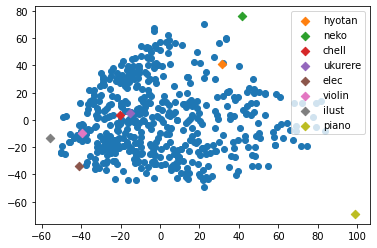

In [23]:
plt.scatter(pdata.T[0],pdata.T[1])
plt.scatter(a_pca_data.T[0][0],a_pca_data.T[1][0],label="hyotan",marker="D")
plt.scatter(a_pca_data.T[0][1],a_pca_data.T[1][1],label="neko",marker="D")
plt.scatter(a_pca_data.T[0][2],a_pca_data.T[1][2],label="chell",marker="D")
plt.scatter(a_pca_data.T[0][3],a_pca_data.T[1][3],label="ukurere",marker="D")
plt.scatter(a_pca_data.T[0][4],a_pca_data.T[1][4],label="elec",marker="D")
plt.scatter(a_pca_data.T[0][5],a_pca_data.T[1][5],label="violin",marker="D")
plt.scatter(a_pca_data.T[0][6],a_pca_data.T[1][6],label="ilust",marker="D")
plt.scatter(a_pca_data.T[0][7],a_pca_data.T[1][7],label="piano",marker="D")
plt.legend()
plt.show()